# Assignment 4

Deadline: 30.04.2025 12:00 CET

<Add your name, student-id and emal address>

## Prerequisites: Library imports, data load and initialization of the backtest service

In [1]:
# Standard library imports
import os
import sys
import copy
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course\\src')    #<Change this path if needed>
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

In [4]:
# Load data
path_to_data = '../data/'  # <change this to your path to data>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.bm_series = load_data_spi(path='../data/')  # <change this if necessary>

In [40]:
# Define rebalancing dates
n_days = 21*3
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
rebdates = market_data_dates[market_data_dates > '2015-01-01'][::n_days].strftime('%Y-%m-%d').tolist()

In [41]:
# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252*3,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

## 1. Maximum Sharpe Ratio Portfolio

a) 

(6 points)

Complete the `MaxSharpe` class below by implementing your its methods `set_objective` and `solve`.
The `solve` method should implement an iterative algorithm that quickly approximates the "true" maximimum Sharpe ratio portfolio (given the estimates of mean and covariance). This approximation should be done by repeatedly solving a mean-variance optimization problem, where the risk aversion parameter (which scales the covariance matrix) is adjusted in each iteration. The algorithm should terminate after a maximum of 10 iterations. 

In [42]:
class MaxSharpe(Optimization):

    def __init__(self,
                 constraints: Optional[Constraints] = None,
                 covariance: Optional[Covariance] = None,
                 expected_return: Optional[ExpectedReturn] = None,
                 **kwargs) -> None:
        super().__init__(
            constraints=constraints,
            **kwargs,
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = ExpectedReturn() if expected_return is None else expected_return

    def set_objective(self, optimization_data: OptimizationData) -> None:
        #<your code here>
        self.optimization_data = optimization_data
    
        X = optimization_data['return_series']
        covmat = self.covariance.estimate(X=X, inplace=False)
        mu = self.expected_return.estimate(X=X, inplace=False)
        
        self.objective = Objective(
            q = mu * -1,
            P = covmat * 2,
        )
        return None

    def solve(self) -> None:
        #<your code here>
        risk_aversion = 1.0
        max_iterations = 10
        tolerance = 1e-6
        
        for i in range(max_iterations):
            self.params['risk_aversion'] = risk_aversion
            super().solve()
            
            weights = pd.Series(self.results['weights'])
            X = self.optimization_data['return_series']
            covmat = self.covariance.estimate(X=X, inplace=False)
            mu = self.expected_return.estimate(X=X, inplace=False)
            
            portf_return = weights @ mu
            portf_variance = weights @ covmat @ weights
            # sharpe_ratio = portf_return / np.sqrt(portf_variance)
            
            # new_risk_aversion = sharpe_ratio / np.sqrt(portf_variance)
            new_risk_aversion = portf_return / portf_variance
            print(f"Iteration {i+1}: risk_aversion={risk_aversion}, new_risk_aversion={new_risk_aversion}")
            
            if abs(new_risk_aversion - risk_aversion) < tolerance:
                break
                
            risk_aversion = new_risk_aversion
        return None

b) 

(2 points)

Provide a theoretical or empirical justification that your algorithm converges to the true maximum Sharpe ratio portfolio for the given coefficients of mean and covariance.
Hint: If you want to provide an empirical justification, you can perform an optimization for a single point in time by running the following code.

In [43]:
# bs.optimization = MaxSharpe(
#     covariance=Covariance(method='pearson'),
#     expected_return=ExpectedReturn(method='geometric'),
#     solver_name='cvxopt',  # <change this to your preferred solver>
#     #<add any other parameters you need, e.g., number of iterations, tolerance, etc.>
# )
# bs.prepare_rebalancing('2015-01-02')
# bs.optimization.set_objective(bs.optimization_data)
# bs.optimization.solve()
# bs.optimization.results
# Update the backtest service with a MaxSharpe optimization object

## 2. Backtest MaxSharpe with Turnover Penalty

(5 points)

Calibrate the turnover penalty parameter such that the backtest of the MaxSharpe strategy displays an annual turnover of roughly 100%.

In [46]:
# Update the backtest service with a MaxSharpe optimization object
bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',
    turnover_penalty=0.00009,  # 这个值需要调整以达到约100%的年化换手率
)

# Prepare rebalancing data
bs.prepare_rebalancing(rebdates[0])  # 使用第一个再平衡日期

# Instantiate the backtest object
bt_ms = Backtest()

# Run the backtest
bt_ms.run(bs = bs)
# 计算年化换手率
n_days = 21*3
n_reb_per_year = 252 / n_days  # 计算每年再平衡次数
turnover = bt_ms.strategy.turnover(return_series=bs.data.get_return_series())
annualized_turnover = turnover.mean() * n_reb_per_year
print(f'Annualized Turnover: {annualized_turnover:.2%}')
# 计算年化换手率
# n_reb_per_year = len(rebdates) / (len(rebdates) / 252)  # 计算每年再平衡次数
# turnover = bt_ms.strategy.turnover(return_series=bs.data.get_return_series())
# annualized_turnover = turnover.mean() * n_reb_per_year
# print(f'Annualized Turnover: {annualized_turnover:.2%}')

# # 如果年化换手率不是100%，调整 turnover_penalty
# if annualized_turnover < 1.0:
#     # 增加 turnover_penalty
#     turnover_penalty = 0.1 * (1.0 / annualized_turnover)
# else:
#     # 减少 turnover_penalty
#     turnover_penalty = 0.1 * annualized_turnover
# 计算年化换手率
# n_reb_per_year = len(rebdates) / (len(rebdates) / 252)
# turnover = bt_ms.strategy.turnover(return_series=bs.data.get_return_series())
# annualized_turnover = turnover.mean() * n_reb_per_year
# print(f'Initial Annualized Turnover: {annualized_turnover:.2%}')

# # 计算并应用调整后的 turnover_penalty
# turnover_penalty = 0.1 * (1.0 / annualized_turnover)
# print(f'Adjusted turnover_penalty: {turnover_penalty:.4f}')


# # 更新优化器并重新运行回测
# bs.optimization = MaxSharpe(
#     covariance=Covariance(method='pearson'),
#     expected_return=ExpectedReturn(method='geometric'),
#     solver_name='cvxopt',
#     turnover_penalty=turnover_penalty,
# )
# bt_ms.run(bs = bs)
# # 插入计算换手率
# turnover = bt_ms.strategy.turnover(return_series=bs.data.get_return_series())
# n_reb_per_year = n_reb_per_year = len(rebdates) / (len(rebdates) / 252)
# annualized_turnover = turnover.mean() * n_reb_per_year
# print(f'Annualized Turnover: {annualized_turnover:.2%}')

Rebalancing date: 2015-01-02
Iteration 1: risk_aversion=1.0, new_risk_aversion=18.060517574580953
Iteration 2: risk_aversion=18.060517574580953, new_risk_aversion=18.060517574580953
Rebalancing date: 2015-04-01
Iteration 1: risk_aversion=1.0, new_risk_aversion=15.785985628549245
Iteration 2: risk_aversion=15.785985628549245, new_risk_aversion=15.785985628549245
Rebalancing date: 2015-06-29
Iteration 1: risk_aversion=1.0, new_risk_aversion=16.51348786153761
Iteration 2: risk_aversion=16.51348786153761, new_risk_aversion=16.51348786153761
Rebalancing date: 2015-09-24
Iteration 1: risk_aversion=1.0, new_risk_aversion=15.036448821445763
Iteration 2: risk_aversion=15.036448821445763, new_risk_aversion=15.036448821445763
Rebalancing date: 2015-12-22
Iteration 1: risk_aversion=1.0, new_risk_aversion=14.687357980903395
Iteration 2: risk_aversion=14.687357980903395, new_risk_aversion=14.687357980903395
Rebalancing date: 2016-03-18
Iteration 1: risk_aversion=1.0, new_risk_aversion=11.73708260968

## 3. Simulation and Descriptive Statistics

(3 points)

- Simulate the portfolio returns from your MaxSharpe backtest. Use fixed costs of 1% and variable costs of 0.3%.
- Plot the cumulated returns of the MaxSharpe strategy together with those of the SPI Index.
- Plot the turnover of your MaxSharpe strategy over time.
- Print the annualized turnover (computed as the average turnover over the backtest multiplied by the number of rebalancing per year) for your MaxSharpe strategy.
- Create and print a table with descriptive performance statistics for your MaxSharpe strategy and the SPI Index.


c:\Users\annaggg\OneDrive\桌面\uzh\quantitative_portfolio_management\assignments\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
c:\Users\annaggg\OneDrive\桌面\uzh\quantitative_portfolio_management\assignments\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


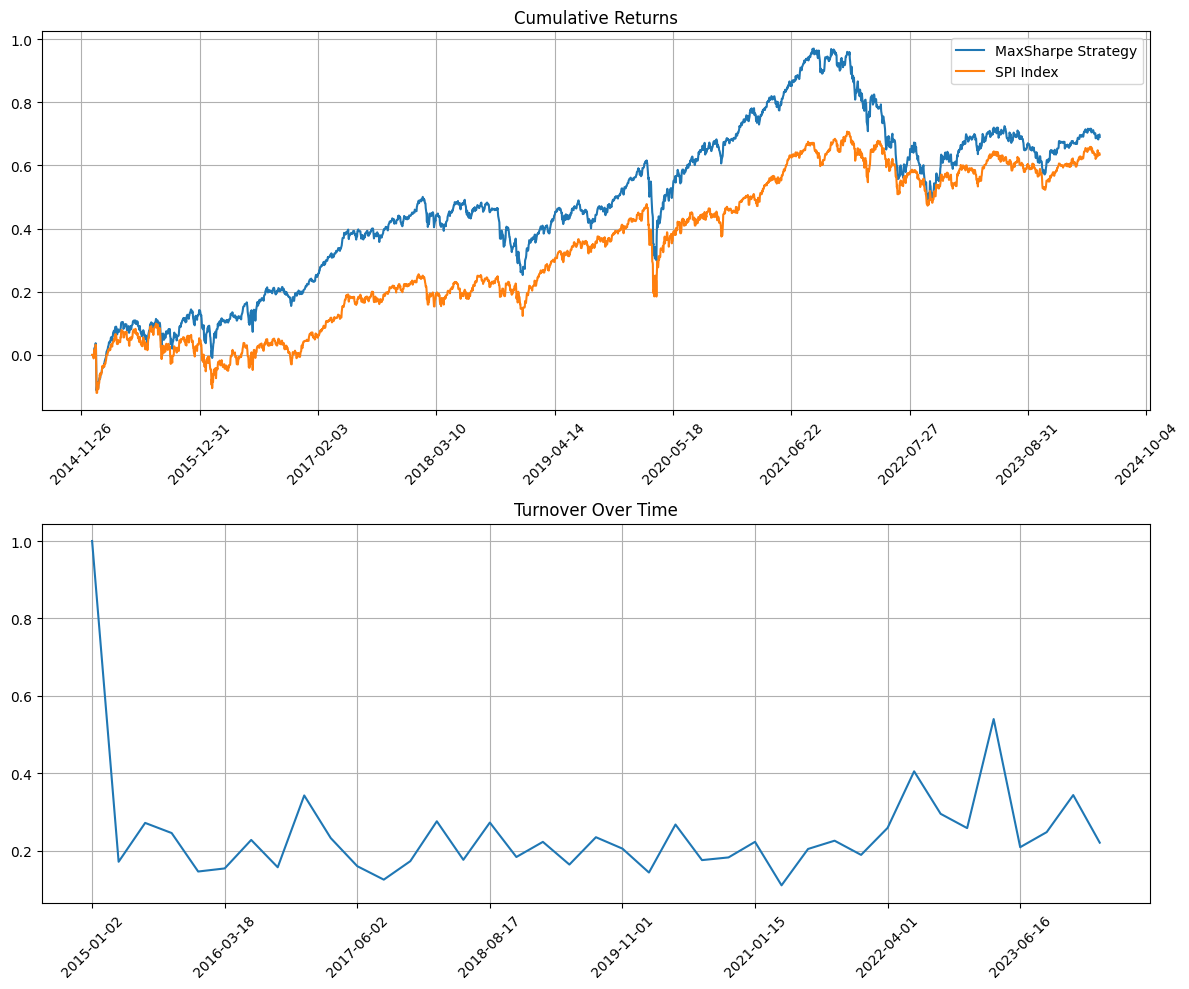

                       MaxSharpe  SPI Index
Annualized Return       0.071515   0.042766
Annualized Volatility   0.157021   0.140087
Sharpe Ratio            0.455452   0.305282
Max Drawdown            0.480515   0.725950


In [47]:
#<your code here>
# Simulate portfolio returns with costs
# Simulate portfolio returns with costs
import matplotlib.pyplot as plt
portf_ret = bt_ms.strategy.simulate(
    return_series=bs.data.get_return_series(),
    fc=0.01,
    vc=0.003
)

# Plot cumulative returns
# plt.figure(figsize=(12, 6))
# plt.plot(portf_ret.cumsum(), label='MaxSharpe Strategy')
# plt.plot(bs.data.bm_series.cumsum(), label='SPI Index')
# plt.title('Cumulative Returns')
# plt.legend()
# plt.show()

# # Plot turnover over time
# plt.figure(figsize=(12, 6))
# plt.plot(bt_ms.strategy.turnover(return_series=bs.data.get_return_series()))
# plt.title('Turnover Over Time')
# plt.show()
# 创建图形
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 绘制累积收益
ax1.plot(portf_ret.cumsum(), label='MaxSharpe Strategy')
ax1.plot(bs.data.bm_series[bs.data.bm_series.index >= '2015-01-01'].cumsum(), label='SPI Index')
ax1.set_title('Cumulative Returns')
ax1.legend()
ax1.grid(True)

# 绘制换手率
ax2.plot(bt_ms.strategy.turnover(return_series=bs.data.get_return_series()))
ax2.set_title('Turnover Over Time')
ax2.grid(True)

# 调整x轴标签
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=45)  # 旋转x轴标签
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # 限制x轴刻度数量

# 调整布局
plt.tight_layout()
plt.show()

# Calculate and print annualized turnover
# 计算年化换手率
# n_days = 21*3
# n_reb_per_year = 252 / n_days  # 计算每年再平衡次数
# turnover = bt_ms.strategy.turnover(return_series=bs.data.get_return_series())
# annualized_turnover = turnover.mean() * n_reb_per_year
# print(f'Annualized Turnover: {annualized_turnover:.2%}')

# Create and print descriptive statistics
stats = pd.DataFrame({
    'MaxSharpe': {
        'Annualized Return': portf_ret.mean() * 252,
        'Annualized Volatility': portf_ret.std() * np.sqrt(252),
        'Sharpe Ratio': portf_ret.mean() / portf_ret.std() * np.sqrt(252),
        'Max Drawdown': (portf_ret.cumsum().expanding().max() - portf_ret.cumsum()).max(),
    },
    'SPI Index': {
        'Annualized Return': bs.data.bm_series.mean() * 252,
        'Annualized Volatility': bs.data.bm_series.std() * np.sqrt(252),
        'Sharpe Ratio': bs.data.bm_series.mean() / bs.data.bm_series.std() * np.sqrt(252),
        'Max Drawdown': (bs.data.bm_series.cumsum().expanding().max() - bs.data.bm_series.cumsum()).max(),
    }
})
print(stats)

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# # 绘制累积收益
# ax1.plot(portf_ret.cumsum(), label='MaxSharpe Strategy')
# ax1.plot(bs.data.bm_series[bs.data.bm_series.index >= '2015-01-01'].cumsum(), label='SPI Index')
# ax1.set_title('Cumulative Returns')
# ax1.legend()
# ax1.grid(True)

# # 绘制换手率
# ax2.plot(bt_ms.strategy.turnover(return_series=bs.data.get_return_series()))
# ax2.set_title('Turnover Over Time')
# ax2.grid(True)

# # 调整布局
# plt.tight_layout()
# plt.show()

# # 计算并打印年化换手率
# n_reb_per_year = len(rebdates) / (len(rebdates) / 252)
# turnover = bt_ms.strategy.turnover(return_series=bs.data.get_return_series())
# annualized_turnover = turnover.mean() * n_reb_per_year
# print(f'Annualized Turnover: {annualized_turnover:.2%}')

# # 创建并打印描述性统计
# stats = pd.DataFrame({
#     'MaxSharpe': {
#         'Annualized Return': portf_ret.mean() * 252,
#         'Annualized Volatility': portf_ret.std() * np.sqrt(252),
#         'Sharpe Ratio': portf_ret.mean() / portf_ret.std() * np.sqrt(252),
#         'Max Drawdown': (portf_ret.cumsum().expanding().max() - portf_ret.cumsum()).max(),
#     },
#     'SPI Index': {
#         'Annualized Return': bs.data.bm_series[bs.data.bm_series.index >= '2015-01-01'].mean() * 252,
#         'Annualized Volatility': bs.data.bm_series[bs.data.bm_series.index >= '2015-01-01'].std() * np.sqrt(252),
#         'Sharpe Ratio': bs.data.bm_series[bs.data.bm_series.index >= '2015-01-01'].mean() / bs.data.bm_series[bs.data.bm_series.index >= '2015-01-01'].std() * np.sqrt(252),
#         'Max Drawdown': (bs.data.bm_series[bs.data.bm_series.index >= '2015-01-01'].cumsum().expanding().max() - bs.data.bm_series[bs.data.bm_series.index >= '2015-01-01'].cumsum()).max(),
#     }
# })
# print(stats)